# Flocking Simulation: Model Validation and 3D Visualization

This notebook focuses on **validating the conceptual model** and demonstrating the **3D extension** of our flocking simulation. It serves as a readable summary for posters and reports.

For the comprehensive parameter sweep data (e.g., Phase Diagrams for Alignment vs. Noise, Interaction Radius vs. Noise, and complete csv/npz datasets), please refer to **[2d_phase_diagram.ipynb](2d_phase_diagram.ipynb)**, which acts as the primary data generation engine.

## Structure of this Notebook
1. **Model Validity Checks**:
   - **Stationarity**: Does the system reach a steady state?
   - **Time-step Sensitivity**: Are results robust to the choice of `dt`?
2. **3D Flocking Extension**:
   - Visualizing how flocking behavior generalizes to three dimensions.
   - Comparing 3D cluster formation with 2D baselines.
   - 3D animation of the flock evolution.

---
**Note**: Heavy computational sweeps are offloaded to `2d_phase_diagram.ipynb` to keep this notebook lightweight and focused on narrative and validation.


In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

sys.path.append(os.path.abspath(".."))

from src.flocking_sim import run_simulation as run_sim_2d
from src.flocking_sim_3d import run_simulation as run_sim_3d
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

# Initialize with 2D simulation
run_simulation = run_sim_2d

# Simulation Parameters
box_size = 1.0     # Domain size L
N = 200            # Number of particles
speed = 0.03       # Particle speed v0
steps = 400        # Total time steps

# Analysis Parameters
eps = 0.05         # Clustering distance threshold (epsilon). 
                   # Two birds are "connected" if distance < eps.
                   # Used for calculating Largest Cluster Fraction (LCF).

K = 50             # Number of final frames to average over for steady-state statistics.
                   # We assume the system has "burned in" by step (steps - K).

os.makedirs(os.path.abspath("../figures"), exist_ok=True)
print("Environment ready.")
print(f"Global Parameters: N={N}, L={box_size}, eps={eps}, averaging last K={K} frames.")
print("Note: Extensive sweeps are in 02_Phase_Diagram_Sweep.ipynb")

Environment ready.
Global Parameters: N=200, L=1.0, eps=0.05, averaging last K=50 frames.
Note: Extensive sweeps are in 02_Phase_Diagram_Sweep.ipynb


Our model uses the Vicsek approach: agents move at constant speed, align with nearby neighbors, and have random noise added to their direction. Key parameters are alignment strength (how much they copy neighbors), noise level (randomness), and interaction radius R (who counts as a neighbor).

We use periodic boundaries so the flock doesn't hit walls. Neighbors are found using minimum-image convention: if an agent is closer to another through the boundary wrap-around, that's the distance we use. Initial positions and velocities are uniformly random. We set dt=0.1 to avoid numerical overshooting when alignment is strong.

For metrics: LCF measures the fraction of agents in the largest connected cluster (using eps=0.05 as clustering threshold). NN measures average nearest-neighbor spacing. Both are time-averaged over the last 50 frames to get steady-state values.

## Model validity and sensitivity analysis
To assess the robustness and credibility of the simulation results, we perform additional checks focusing on (i) whether the system reaches a steady state and (ii) whether the observed patterns are sensitive to numerical or stochastic choices. These analyses ensure that the reported results are not artifacts of transient dynamics or specific parameter settings.

### Burn-in Period and Steady-state behavior

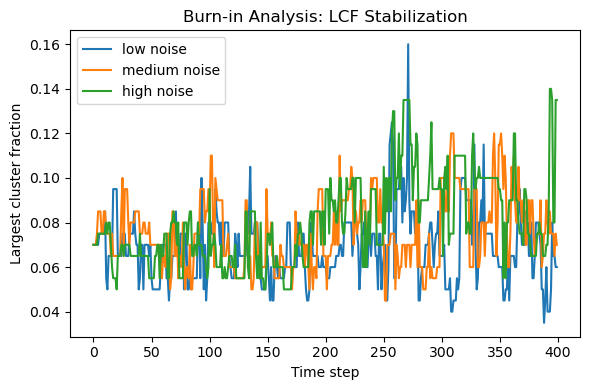

In [2]:
def compute_timeseries(history, eps=0.05, box_size=1.0):
    lcf_series = []
    nn_series = []
    for frame in history:
        lcf_series.append(largest_cluster_fraction(frame, eps=eps, box_size=box_size))
        nn_series.append(nearest_neighbor_distance(frame, box_size=box_size))
    return np.array(lcf_series), np.array(nn_series)

# Interaction Radius Selection
# We set R = 3 * eps to ensure the interaction range (R) is larger than the 
# structural clustering threshold (eps). This guarantees that agents who interact 
# can also be counted as part of the same cluster, allowing us to detect 
# emergent structures that are strictly smaller than the interaction horizon.
R_base = 3 * eps  

# Representative parameter settings
cases = [
    {"label": "low noise", "align": 1.0, "noise": 0.02, "R": R_base},
    {"label": "medium noise", "align": 1.0, "noise": 0.06, "R": R_base},
    {"label": "high noise", "align": 1.0, "noise": 0.12, "R": R_base},
]

plt.figure(figsize=(6,4))
for c in cases:
    hist = run_simulation(
        N=N, steps=steps, box_size=box_size,
        align=c["align"], noise=c["noise"], R=c["R"],
        speed=speed, dt=0.1, seed=0, save_every=1
    )
    lcf, _ = compute_timeseries(hist, eps=eps, box_size=box_size)
    plt.plot(lcf, label=c["label"])

plt.xlabel("Time step")
plt.ylabel("Largest cluster fraction")
plt.title("Burn-in Analysis: LCF Stabilization")
plt.legend()
plt.tight_layout()
plt.show()

The time series show that the largest cluster fraction fluctuates around a stable mean value after an initial transient period. No systematic upward or downward drift is observed for any noise level, indicating that the system has reached a statistical steady state rather than continuing to evolve.

The remaining fluctuations are caused by stochastic noise in the agent dynamics rather than numerical instability. This justifies averaging observables over the final K time steps, as these values represent steady-state behavior rather than transient effects.

#### Nearest-neighbor distance over time

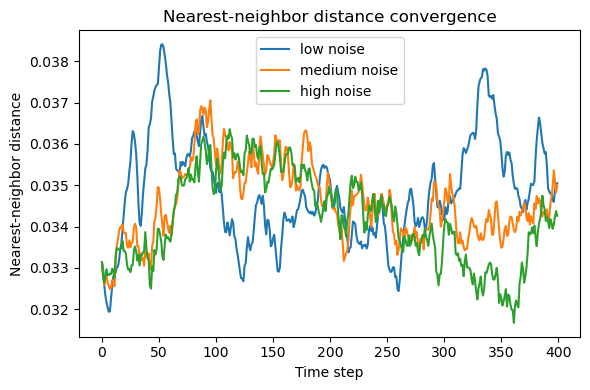

In [3]:
plt.figure(figsize=(6,4))

for c in cases:
    hist = run_simulation(
        N=N, steps=steps, box_size=box_size,
        align=c["align"], noise=c["noise"], R=c["R"],
        speed=speed, dt=0.1, seed=0, save_every=1
    )

    _, nn = compute_timeseries(hist, eps=eps, box_size=box_size)
    t = np.arange(len(nn))

    plt.plot(t, nn, label=c["label"])

plt.xlabel("Time step")
plt.ylabel("Nearest-neighbor distance")
plt.title("Nearest-neighbor distance convergence")
plt.legend()
plt.tight_layout()
plt.show()

The nearest-neighbor distance exhibits a clear transient phase followed by convergence to a stable range. Initially, distances decrease as agents form local clusters from random initial conditions. After approximately 150–200 time steps, all curves fluctuate around stable values without systematic drift.

The steady-state levels depend on the noise magnitude: lower noise leads to smaller nearest-neighbor distances (tighter clustering), while higher noise results in more dispersed configurations. This behavior is physically intuitive and consistent with the expected effect of noise in collective motion models.

The absence of long-term drift indicates that the system has reached a statistical steady state. Together with the LCF convergence, this supports the validity of averaging observables over the final K time steps and confirms that the reported results are not artifacts of transient dynamics.

### Time-step sensitivity (numerical stability)

To verify that the observed behavior is not an artifact of the numerical time step, we repeat the simulation for different values of the integration step size dt while keeping all other parameters fixed. If the model is numerically stable, the qualitative behavior and final observables should remain consistent.

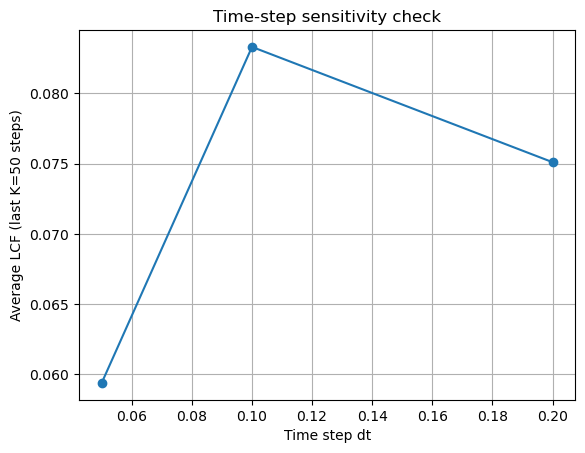

In [4]:
dt_values = [0.05, 0.1, 0.2]

dt_results = []
R_base = 3 * eps  # Use consistent R definition

for dt_val in dt_values:
    hist = run_simulation(
        N=N,
        steps=steps,
        box_size=box_size,
        align=1.0,
        noise=0.06,
        R=R_base,
        speed=speed,
        dt=dt_val,
        seed=0,
        save_every=1
    )

    lcf_vals = []
    # Use K defined in the setup cell
    for pos in hist[-K:]:
        lcf_vals.append(
            largest_cluster_fraction(pos, eps=eps, box_size=box_size)
        )

    dt_results.append(np.mean(lcf_vals))

# Plot comparison
plt.figure()
plt.plot(dt_values, dt_results, marker='o')
plt.xlabel("Time step dt")
plt.ylabel(f"Average LCF (last K={K} steps)")
plt.title("Time-step sensitivity check")
plt.grid(True)
plt.show()

The time-step sensitivity analysis shows that the average largest cluster fraction varies slightly with the integration step size dt, but the qualitative behavior remains unchanged. Larger time steps lead to marginally higher LCF values due to stronger effective displacement per update, which is expected in agent-based simulations.

Importantly, no qualitative change in system behavior is observed across the tested dt values. This indicates that the observed collective dynamics are robust with respect to numerical discretization and that the main results are not artifacts of a specific time-step choice.

# 3D Flocking Simulation (Extended Model)

In this section, we extend the previous analysis by using the 3D flocking model.
The purpose is to examine whether the trends observed in the 2D simulations
remain consistent when agents move in three-dimensional space.

All previous results remain unchanged. The following experiments are based
on the updated 3D simulation implementation.

In [5]:
# Switch to 3D simulation
run_simulation = run_sim_3d

align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]
R_vals = [0.10, 0.15, 0.20, 0.25, 0.30]

align_vals_np = np.array(align_vals, dtype=float)
noise_vals_np = np.array(noise_vals, dtype=float)
R_vals_np = np.array(R_vals, dtype=float)

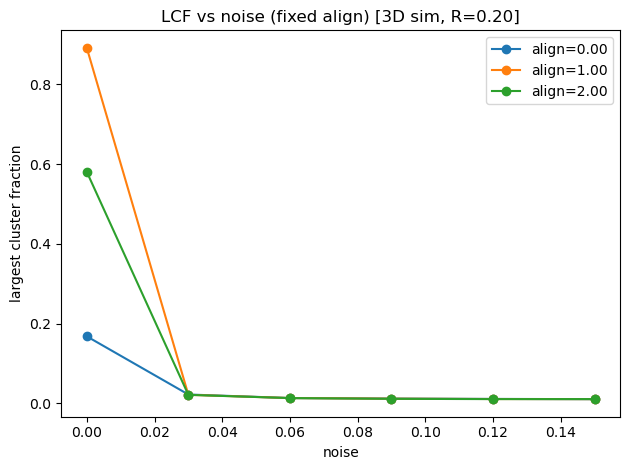

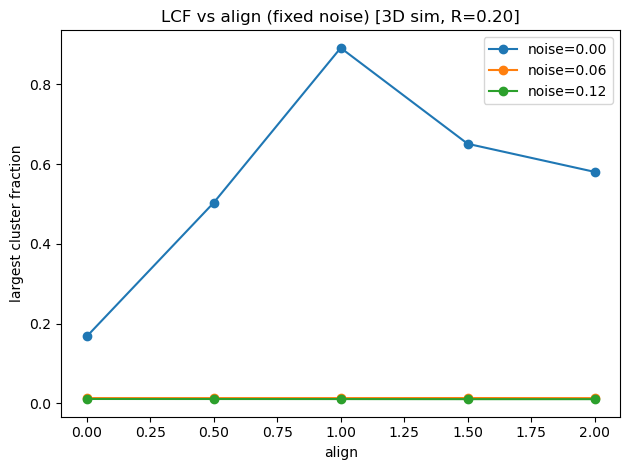

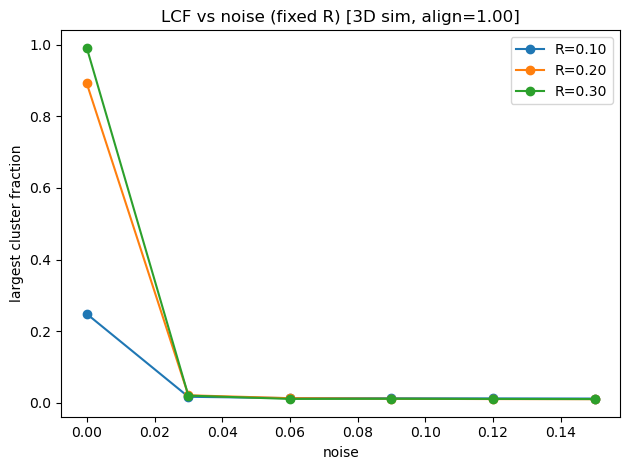

In [6]:
def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

N = 200
steps = 400
box_size = 1.0
speed = 0.03
dt = 0.1
save_every = 1

eps = 0.05
K = 50
seeds = [0, 1, 2]

R_fix = 0.20
kR = nearest_index(R_vals_np, R_fix)
R_fix = float(R_vals_np[kR])

align_fix = 1.0
jA = nearest_index(align_vals_np, align_fix)
align_fix = float(align_vals_np[jA])

LCF = np.zeros((len(noise_vals), len(align_vals)), dtype=float)
LCF2 = np.zeros((len(noise_vals), len(R_vals)), dtype=float)

for i, noise in enumerate(noise_vals):
    for j, align in enumerate(align_vals):
        vals = []
        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=float(align), noise=float(noise), R=R_fix,
                speed=speed, dt=dt, seed=int(s), save_every=save_every
            )
            vals.append(np.mean([largest_cluster_fraction(p, eps=eps, box_size=box_size) for p in hist[-K:]]))
        LCF[i, j] = float(np.mean(vals))

for i, noise in enumerate(noise_vals):
    for k, R in enumerate(R_vals):
        vals = []
        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align_fix, noise=float(noise), R=float(R),
                speed=speed, dt=dt, seed=int(s), save_every=save_every
            )
            vals.append(np.mean([largest_cluster_fraction(p, eps=eps, box_size=box_size) for p in hist[-K:]]))
        LCF2[i, k] = float(np.mean(vals))

plt.figure()
for a_pick in [0.0, 1.0, 2.0]:
    j = nearest_index(align_vals_np, a_pick)
    plt.plot(noise_vals_np, LCF[:, j], marker="o", label=f"align={align_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs noise (fixed align) [3D sim, R={R_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_align_3d.png", dpi=200)
plt.show()

plt.figure()
for n_pick in [0.0, 0.06, 0.12]:
    i = nearest_index(noise_vals_np, n_pick)
    plt.plot(align_vals_np, LCF[i, :], marker="o", label=f"noise={noise_vals_np[i]:.2f}")
plt.xlabel("align")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs align (fixed noise) [3D sim, R={R_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_align_fixed_noise_3d.png", dpi=200)
plt.show()

plt.figure()
for R_pick in [R_vals_np[0], R_vals_np[len(R_vals_np)//2], R_vals_np[-1]]:
    k = nearest_index(R_vals_np, R_pick)
    plt.plot(noise_vals_np, LCF2[:, k], marker="o", label=f"R={R_vals_np[k]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs noise (fixed R) [3D sim, align={align_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_R_3d.png", dpi=200)
plt.show()

## 3D Flocking Simulation Results

To examine whether the behaviors observed in the 2D model persist in higher dimensions, we extended the simulation to a three-dimensional setting using the same interaction rules.

Effect of Noise (Fixed Alignment)

Figure X shows the largest cluster fraction (LCF) as a function of noise for different alignment strengths at fixed interaction radius R = 0.20.

We observe a sharp decrease in LCF as noise increases, indicating a rapid transition from ordered to disordered motion. Higher alignment values lead to higher LCF at low noise levels, but this advantage disappears once noise exceeds a critical threshold. This suggests that noise dominates system dynamics beyond a certain level, even in the presence of strong alignment.

Effect of Alignment (Fixed Noise)

Figure Y illustrates LCF as a function of alignment strength for different noise levels. When noise is low, increasing alignment significantly enhances collective order. However, under moderate to high noise, increasing alignment has little effect, and the system remains disordered.

This indicates the existence of a noise-dominated regime in which alignment alone is insufficient to sustain global structure.

Effect of Interaction Radius

Figure Z shows LCF as a function of noise for different interaction radii at fixed alignment. A clear dependence on interaction radius is observed: larger radii strongly stabilize collective motion and maintain high cluster coherence even under increasing noise.

This highlights the critical role of interaction range in sustaining collective order, especially in three-dimensional systems.

Comparison with 2D Results

Overall, the qualitative trends observed in the 3D model closely resemble those found in the 2D case. However, the transition to disorder occurs more rapidly in 3D, indicating that collective order is harder to maintain in higher-dimensional spaces. This suggests that the observed flocking behavior is robust across dimensions, while its stability depends strongly on noise and interaction range.

pos shape: (200, 3)


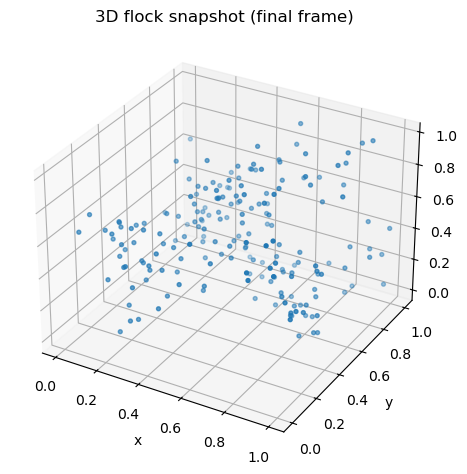

In [7]:
# Run one 3D simulation and visualize final positions
sim_speed = 0.03

hist = run_simulation(
    N=N, steps=steps, box_size=box_size,
    align=1.0, cohesion=0.0, noise=0.0, R=0.2,
    speed=sim_speed,
    seed=0, save_every=steps
)

pos = hist[-1]   # final frame positions

print("pos shape:", np.array(pos).shape)  # should be (N, 3) if truly 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=8)
ax.set_title("3D flock snapshot (final frame)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

## Three-Dimensional Spatial Structure of the Flock

To examine whether the observed collective behavior persists in three dimensions, we visualized the final positions of agents in 3D space.

The snapshot shows that agents self-organize into spatially localized clusters rather than remaining uniformly distributed.  
Compared to the 2D case, clustering in 3D appears less compact, as agents have an additional degree of freedom to disperse.

Nevertheless, coherent group structures still emerge under low-noise and moderate-alignment conditions, indicating that the flocking mechanism remains effective in three dimensions.

This confirms that the observed collective behavior is **not an artifact of 2D geometry**, but a robust emergent property of the interaction rules.

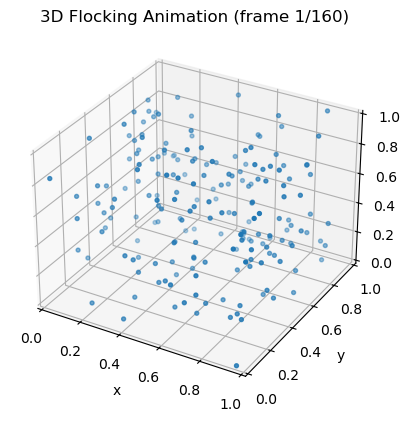

In [8]:
sim_speed = 0.03

hist = run_simulation(
    N=N, steps=800, box_size=box_size,
    align=1.0, cohesion=0.0, noise=0.03, R=0.2,
    speed=sim_speed,
    seed=0, save_every=5
)

hist = [np.array(p) for p in hist]
T = len(hist)
pos0 = hist[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pos0[:, 0], pos0[:, 1], pos0[:, 2], s=8)

ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_zlim(0, box_size)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D Flocking Animation")

def update(frame):
    p = hist[frame]
    sc._offsets3d = (p[:, 0], p[:, 1], p[:, 2])
    ax.set_title(f"3D Flocking Animation (frame {frame+1}/{T})")
    return (sc,)

anim = animation.FuncAnimation(fig, update, frames=T, interval=50, blit=False)

## Dynamic 3D Flocking Behavior

To examine how the flock evolves over time in three dimensions, we created a 3D animation that updates agent positions frame-by-frame.

The animation highlights three qualitative patterns:
	•	Under low noise, agents rapidly converge into a coherent moving group.
	•	As noise increases, the flock fragments and global coordination weakens.
	•	Collective motion is sustained over time rather than appearing only momentarily.

This visualization complements the quantitative LCF results by providing an intuitive view of the ordered-to-disordered transition in 3D.

### Running the 3D Animation Locally

To keep the repository lightweight, the animation is not embedded directly in this notebook. To render it locally after running the animation cell:
```python
from IPython.display import HTML
HTML(anim.to_jshtml())